In [1]:
import os
import sys
sys.path.append(os.getcwd())

from lib.models.model_execution_support import run_mod_with_correction_block_on_inputs_with_targets
from lib.models.model_execution_support import run_on_inputs_with_targets
from lib.models.potentially_recurrent_forecaster import PRForecaster
from lib.models.prerecorded_forecaster import PrerecordedForecaster
from lib.models.recurrent_forecaster_with_correction_block import RecurrentForecasterWithCorrectionBlock
from lib.models.recurrent_sigmoid_piecewise_forecaster import RSPForecaster, StackedRCellsForecaster
from lib.models.recurrent_sigmoid_piecewise_forecaster import LSTMForecaster, GRUForecaster
from lib.models.linear_forecaster import LinearForecaster
from lib.utils.metrics import print_metrics
from lib.utils.recurrent_contexts_manager import RecurrentContextsManager

from __future__ import print_function
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import pandas_datareader as pdr
import pandas as pd
import pandas_datareader.data as web
import xgboost

from typing import Any
from typing import Optional
from typing import Tuple
from uuid import uuid4
import datetime
import time

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [2]:
import lightning.pytorch as pl
from lightning.pytorch.callbacks import EarlyStopping
import pandas as pd
import torch

from pytorch_forecasting import Baseline, NBeats, TimeSeriesDataSet
from pytorch_forecasting.data import NaNLabelEncoder
from pytorch_forecasting.data.examples import generate_ar_data
from pytorch_forecasting.metrics import SMAPE

/home/ivan/miniconda3/envs/ml_env/lib/python3.8/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: /home/ivan/miniconda3/envs/ml_env/lib/python3.8/site-packages/torchvision/image.so: undefined symbol: _ZN3c104cuda20CUDACachingAllocator12recordStreamERKNS_7DataPtrENS0_10CUDAStreamE
  warn(f"Failed to load image Python extension: {e}")


In [3]:
DEVICE = 'cpu'
DTYPE = torch.float32

# set random seed to 0
np.random.seed(0)
torch.manual_seed(0)

torch.set_printoptions(precision=10)

In [4]:
df = pd.read_csv('heart_rate.csv')
print(df['T4'][890])
heart_data = np.array(df[:891]).transpose(1, 0)
heart_data = heart_data / (heart_data.max() - heart_data.min())
heart_data = heart_data - heart_data.mean()
print(heart_data)
print(heart_data.shape)

62.0
[[ 0.14598108  0.14598108  0.14204635 ...  0.4683017   0.45550151
   0.43827048]
 [ 0.28219521  0.28219521  0.27689336 ...  0.40076932  0.38879281
   0.38256881]
 [-0.30440775 -0.30440775 -0.30484894 ... -0.36155229 -0.35393276
  -0.34546305]
 [-0.32704289 -0.32704289 -0.32704289 ... -0.29516359 -0.26901976
  -0.2757001 ]]
(4, 891)


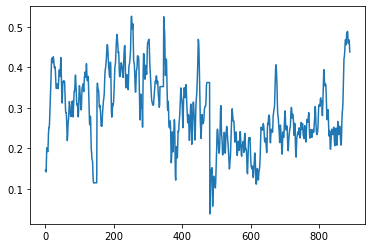

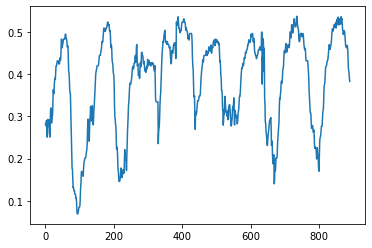

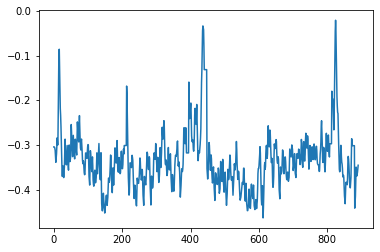

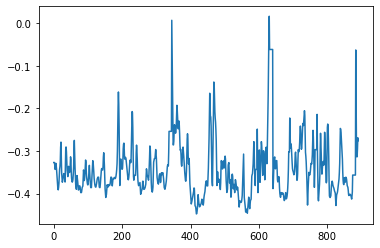

In [5]:
plt.figure()
plt.plot(range(heart_data.shape[1]), heart_data[0, :])
plt.figure()
plt.plot(range(heart_data.shape[1]), heart_data[1, :])
plt.figure()
plt.plot(range(heart_data.shape[1]), heart_data[2, :])
plt.figure()
plt.plot(range(heart_data.shape[1]), heart_data[3, :])

In [6]:
start = datetime.datetime(2015, 1, 1)
end = datetime.datetime(2023, 1, 1)

f = web.DataReader('^DJI', 'stooq', start, end)
ts = np.flip(f['Open'].values, axis=0).copy()
ts = ts / (ts.max() - ts.min())
ts = ts - ts.mean()

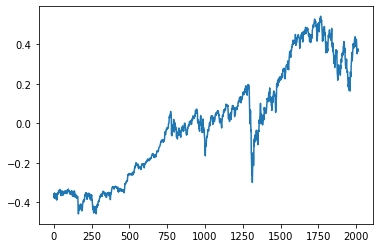

In [7]:
plt.figure()
plt.plot(range(len(ts)), ts)
plt.show()

Text(0.5, 1.0, 'Test')

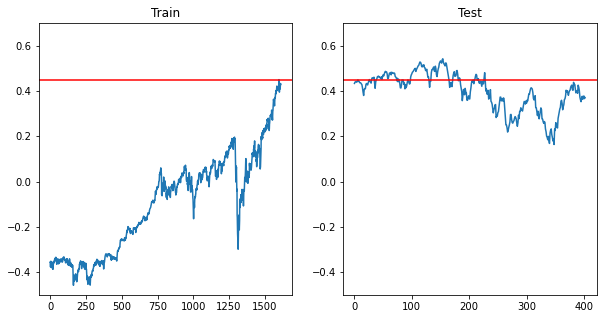

In [8]:
train_end = int(0.8 * len(ts))
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(range(train_end), ts[:train_end], scalex=True, scaley=False)
plt.ylim(-0.5, 0.7)
plt.axhline(y=0.45, color='r')
plt.title('Train')
plt.subplot(1, 2, 2)
plt.plot(range(len(ts[train_end:])), ts[train_end:])
plt.ylim(-0.5, 0.7)
plt.axhline(y=0.45, color='r')
plt.title('Test')

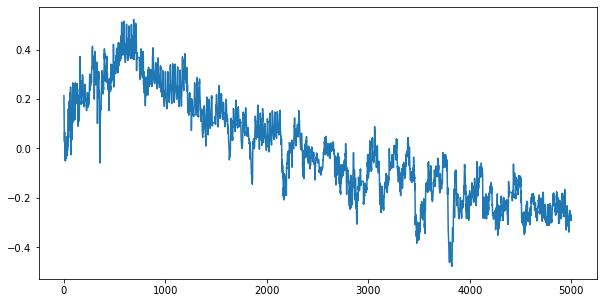

In [109]:
etth = pd.read_csv('/home/ivan/Downloads/ETTh1.csv')
ot_ts = np.array(etth['OT'])[:5000]
ot_ts = ot_ts / (ot_ts.max() - ot_ts.min())
ot_ts = ot_ts - ot_ts.mean()
plt.figure(figsize=(10, 5))
plt.plot(range(len(ot_ts)), ot_ts)

In [110]:
INP_SIZE = 2

def sw(t: torch.Tensor) -> torch.Tensor:
    return t.unfold(dimension=1, size=INP_SIZE, step=1)

def get_train_test_data_heart_rate(heart_data, train_ratio=0.9):
    N = heart_data.shape[1]
    train_size = int(N * train_ratio)
    test_size = N - train_size
    train_ts = heart_data[:, :train_size]
    test_ts = heart_data[:, train_size:]
    return (
        sw(torch.from_numpy(train_ts[:, :-1])).permute(1, 0, 2).to(DEVICE, dtype=DTYPE),
        torch.from_numpy(train_ts[:, INP_SIZE:]).permute(1, 0).unsqueeze(-1).to(DEVICE, dtype=DTYPE),
        sw(torch.from_numpy(test_ts[:, :-1])).permute(1, 0, 2).to(DEVICE, dtype=DTYPE),
        torch.from_numpy(test_ts[:, INP_SIZE:]).permute(1, 0).unsqueeze(-1).to(DEVICE, dtype=DTYPE),
    )


def get_train_test_data_from_ts(ts: np.ndarray, train_ratio=0.9):
    N = len(ts)
    train_size = int(N * train_ratio)
    test_size = N - train_size
    train_ts = ts[:train_size]
    test_ts = ts[train_size:]
    return (
        sw(torch.from_numpy(train_ts[:-1]).view(1, train_size - 1)).permute(1, 0, 2).to(DEVICE, dtype=DTYPE),
        torch.from_numpy(train_ts[INP_SIZE:])[:, None, None].to(DEVICE, dtype=DTYPE),
        sw(torch.from_numpy(test_ts[:-1]).view(1, test_size - 1)).permute(1, 0, 2).to(DEVICE, dtype=DTYPE),
        torch.from_numpy(test_ts[INP_SIZE:])[:, None, None].to(DEVICE, dtype=DTYPE)
    )


# inp, target, test_input, test_target = get_train_test_data_heart_rate(heart_data, train_ratio=0.8)

inp, target, test_input, test_target = get_train_test_data_from_ts(ot_ts, train_ratio=0.8)
print(inp.shape, target.shape, test_input.shape, test_target.shape)
print(target.max())

torch.Size([3998, 1, 2]) torch.Size([3998, 1, 1]) torch.Size([998, 1, 2]) torch.Size([998, 1, 1])
tensor(0.5225287080)


In [111]:
cm = RecurrentContextsManager()
baseline = LinearForecaster.find_optimal_least_squares_forecaster(cm, inp, target, bias=True)
print(baseline.predictor.weight.data)
print(baseline.predictor.bias.data)

tensor([[0.0184530597, 0.9750075936]])
tensor([0.0002792125])


Metrics for linear train:
	 MSE: 0.0005037738592363894
	 MAE: 0.015377508476376534
	 MAPE: 0.22720499336719513


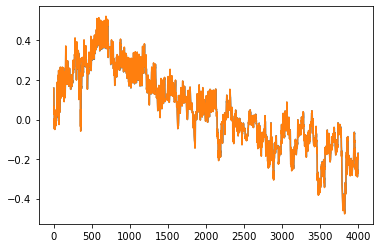

In [112]:
lin_train_out = run_on_inputs_with_targets(baseline, inp, target, setup_ctxs=False, delete_ctxs=False)
print_metrics(lin_train_out, target, 'linear train')
N, S, one = target.shape
SEQ_IDX = 0
plt.figure()
plt.plot(np.arange(N), lin_train_out[:, SEQ_IDX, :].detach())
plt.plot(np.arange(N), target[:, SEQ_IDX, :].detach())
plt.show()

Metrics for linear test:
	 MSE: 0.0003699038061313331
	 MAE: 0.0136873759329319
	 MAPE: 0.0666733905673027


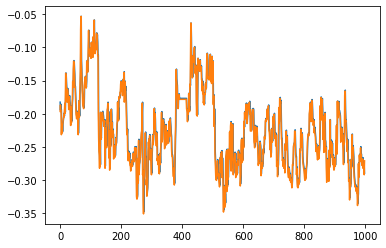

In [113]:
lin_test_out = run_on_inputs_with_targets(baseline, test_input, test_target,
                                                setup_ctxs=False, delete_ctxs=False)
print_metrics(lin_test_out, test_target, 'linear test')
N, S, one = test_target.shape
SEQ_IDX = 0
plt.figure()
plt.plot(np.arange(N), lin_test_out[:, SEQ_IDX, :].detach())
plt.plot(np.arange(N), test_target[:, SEQ_IDX, :].detach())
plt.show()

Metrics for xgboost train:
	 MSE: 0.00020810340356547385
	 MAE: 0.010384008288383484
	 MAPE: 0.17669396102428436


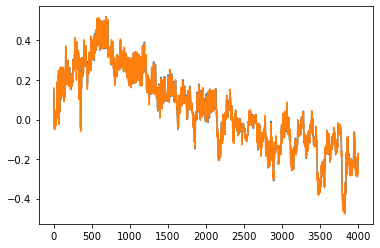

In [114]:
xgbreg = xgboost.XGBRegressor(objective='reg:squarederror')
N, S, M = inp.shape
inp_2d = inp.reshape(-1, M)
target_2d =target.reshape(-1, 1)
xgbreg.fit(inp_2d, target_2d)
out_2d = xgbreg.predict(inp_2d)
xgb_train_out = torch.from_numpy(out_2d.reshape(-1, S, 1))
N = target.shape[0]
plt.plot(np.arange(N), xgb_train_out[:, SEQ_IDX, :])
plt.plot(np.arange(N), target[:, SEQ_IDX, :].detach())
print_metrics(xgb_train_out, target, 'xgboost train')

Metrics for xgboost test:
	 MSE: 0.0005019609234295785
	 MAE: 0.016825439408421516
	 MAPE: 0.08094963431358337


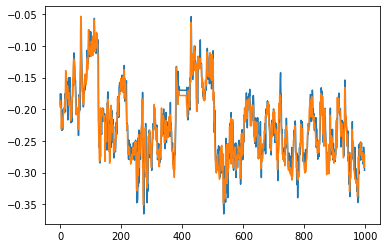

In [115]:
xgb_test_out = torch.from_numpy(xgbreg.predict(test_input.reshape(-1, M)).reshape(-1, S, 1))
N = test_target.shape[0]
plt.plot(np.arange(N), xgb_test_out[:, SEQ_IDX, :])
plt.plot(np.arange(N), test_target[:, SEQ_IDX, :].detach())
print_metrics(xgb_test_out, test_target, 'xgboost test')

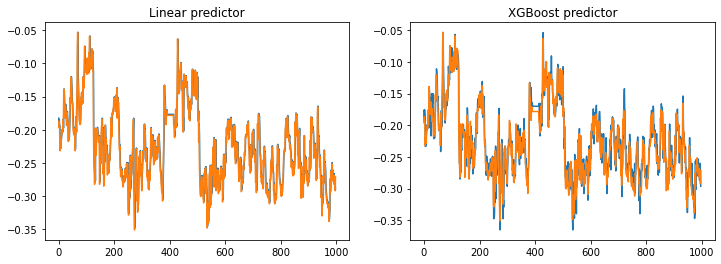

In [116]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(np.arange(N), lin_test_out[:, SEQ_IDX, :].detach())
plt.plot(np.arange(N), test_target[:, SEQ_IDX, :].detach())
plt.title('Linear predictor')
plt.subplot(1, 2, 2)
plt.plot(np.arange(N), xgb_test_out[:, SEQ_IDX, :].detach())
plt.plot(np.arange(N), test_target[:, SEQ_IDX, :].detach())
plt.title('XGBoost predictor')
plt.show()

In [17]:
data = pd.DataFrame()
data['value'] = ts
data['series'] = 0
data['time_idx'] = range(len(ts))
data['static'] = 2
data.head()

,value,series,time_idx,static
0,-0.355947,0,0,2
1,-0.356031,0,1,2
2,-0.371099,0,2,2
3,-0.377247,0,3,2
4,-0.366928,0,4,2


In [65]:
max_encoder_length = 60
max_prediction_length = 1 # 20

context_length = max_encoder_length
prediction_length = max_prediction_length

training_cutoff = int(len(ts) * 0.9)

training = TimeSeriesDataSet(
    data[lambda x: x.time_idx <= training_cutoff],
    time_idx="time_idx",
    target="value",
    categorical_encoders={"series": NaNLabelEncoder().fit(data.series)},
    group_ids=["series"],
    # only unknown variable is "value" - and N-Beats can also not take any additional variables
    time_varying_unknown_reals=["value"],
    max_encoder_length=context_length,
    max_prediction_length=prediction_length,
)

validation = TimeSeriesDataSet.from_dataset(training, data, min_prediction_idx=training_cutoff + 1)
batch_size = 128
train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=8)
val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size, num_workers=8)

In [69]:
# calculate baseline absolute error
actuals = torch.cat([y[0] for x, y in iter(val_dataloader)])
baseline_predictions = Baseline().predict(val_dataloader)
SMAPE().to(device='cpu')(baseline_predictions.to(device='cpu'), actuals.to(device='cpu'))

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


tensor(0.0461136103)

In [67]:
pl.seed_everything(42)
trainer = pl.Trainer(accelerator="auto", gradient_clip_val=0.01)
net = NBeats.from_dataset(training, learning_rate=3e-2, weight_decay=1e-2, widths=[32, 512], backcast_loss_ratio=0.1)

Global seed set to 42
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


/home/ivan/miniconda3/envs/ml_env/lib/python3.8/site-packages/lightning/pytorch/loops/utilities.py:72: PossibleUserWarning: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
  rank_zero_warn(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/ivan/miniconda3/envs/ml_env/lib/python3.8/site-packages/lightning/pytorch/loops/fit_loop.py:281: PossibleUserWarning: The number of training batches (10) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=100` reached.
Learning rate set to 0.3548133892335755
Restoring states from the checkpoint path at /home/ivan/my_projects/nau_forecasting/.lr_find_efabfa1f-4f4c-4db3-88d4-824743d3a847.ckpt
Restored all states from the checkpoint at /home/ivan/my_projects/nau_forecasting/.lr_find_efabfa1f-4f4c-4db3-88d4-824743d3a847.ckpt


suggested learning rate: 0.3548133892335755


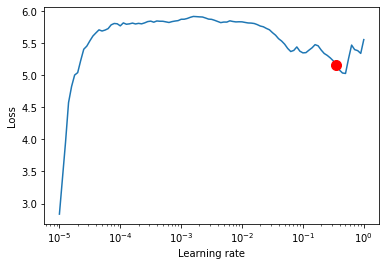

/tmp/ipykernel_26957/330161667.py:7: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


In [68]:
# find optimal learning rate
from lightning.pytorch.tuner import Tuner

res = Tuner(trainer).lr_find(net, train_dataloaders=train_dataloader, val_dataloaders=val_dataloader, min_lr=1e-5)
print(f"suggested learning rate: {res.suggestion()}")
fig = res.plot(show=True, suggest=True)
fig.show()
net.hparams.learning_rate = res.suggestion()

In [75]:
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=10, verbose=False, mode="min")
trainer = pl.Trainer(
    max_epochs=100,
    accelerator="auto",
    enable_model_summary=True,
    gradient_clip_val=0.01,
    callbacks=[early_stop_callback],
    limit_train_batches=150,
)


net = NBeats.from_dataset(
    training,
    learning_rate=0.01,
    log_interval=10,
    log_val_interval=1,
    weight_decay=1e-2,
    widths=[32, 512],
    backcast_loss_ratio=1.0,
)

trainer.fit(
    net,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type       | Params
-----------------------------------------------
0 | loss            | MASE       | 0     
1 | logging_metrics | ModuleList | 0     
2 | net_blocks      | ModuleList | 1.7 M 
-----------------------------------------------
1.7 M     Trainable params
0         Non-trainable params
1.7 M     Total params
6.735     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

In [76]:
best_model_path = trainer.checkpoint_callback.best_model_path
best_model = NBeats.load_from_checkpoint(best_model_path)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


torch.Size([1316, 1])
torch.Size([1316, 1])
1316
Metrics for Nbeats train:
	 MSE: 0.00018141431792173535
	 MAE: 0.007661908399313688
	 MAPE: 0.062557153403759


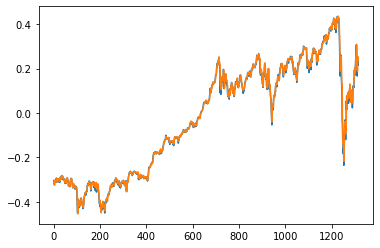

In [92]:
dataloader = training.to_dataloader(train=False, batch_size=batch_size, num_workers=8)
actuals = torch.cat([y[0] for x, y in iter(dataloader)]).cpu()
predictions = best_model.predict(dataloader).cpu()
N = len(predictions)
plt.plot(np.arange(N), actuals)
plt.plot(np.arange(N), predictions)
print_metrics(actuals, predictions, 'Nbeats train')


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Metrics for Nbeats test:
	 MSE: 0.0004390451649669558
	 MAE: 0.015731660649180412
	 MAPE: 0.047892022877931595


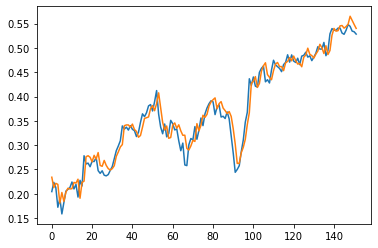

In [93]:
dataloader = validation.to_dataloader(train=False, batch_size=batch_size, num_workers=8)
actuals = torch.cat([y[0] for x, y in iter(dataloader)]).cpu()
predictions = best_model.predict(dataloader).cpu()
N = len(predictions)
plt.plot(np.arange(N), actuals)
plt.plot(np.arange(N), predictions)
print_metrics(actuals, predictions, 'Nbeats test')

In [62]:
preds, x, *_ = best_model.predict(val_dataloader, mode="raw", return_x=True)
print(len(actuals))

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


133


In [133]:
HIDDEN_SIZE = 6
NUM_CELLS = 2
LR = 0.06
STEPS = 100

start = time.perf_counter_ns()

# INP_SIZE + 3 because correction block also takes baseline
# forecast, previous baseline error and previous actual error
# as extra inputs
corrector = StackedRCellsForecaster(cm, INP_SIZE + 3, HIDDEN_SIZE, NUM_CELLS,
                                   CellType=RSPForecaster) # RSPForecaster(cm, INP_SIZE + 3, HIDDEN_SIZE)  

train_out = lin_train_out
test_out = lin_test_out
NOISE = 0.015


baseline = PrerecordedForecaster(cm, train_out, test_out)

model = RecurrentForecasterWithCorrectionBlock(cm, baseline, corrector)

best_test_loss = None
criterion = nn.MSELoss()
# use LBFGS as optimizer since we can load the whole data to train
optimizer = optim.Adam(model.parameters(), lr=LR)# optim.SGD(model.parameters(), lr=LR) #optim.LBFGS(model.parameters(), lr=LR)
test_losses = []
#begin to train
for i in range(STEPS):
    train_out_with_noise = train_out + torch.randn_like(train_out) * NOISE
    baseline.train_targets = train_out_with_noise
    print('STEP: ', i)
    if isinstance(optimizer, optim.LBFGS):
        def closure():
            optimizer.zero_grad()
            out, corrections = run_mod_with_correction_block_on_inputs_with_targets(
                model, inp, target, baseline_no_grad=True, model_mode=PRForecaster.MODE_TRAIN)
            loss = criterion(out, target)
            print('loss:', loss.item())
            loss.backward()
            return loss
        optimizer.step(closure)
    else:
        optimizer.zero_grad()
        out, corrections = run_mod_with_correction_block_on_inputs_with_targets(
            model, inp, target, baseline_no_grad=True, model_mode=PRForecaster.MODE_TRAIN)
        loss = criterion(out, target)
        print('loss: ', loss.item())
        loss.backward()
        optimizer.step()
    # begin to predict, no need to track gradient here
    with torch.no_grad():
        pred, corrections = run_mod_with_correction_block_on_inputs_with_targets(
            model, test_input, test_target, baseline_no_grad=True, model_mode=PRForecaster.MODE_TEST)
        loss = criterion(pred, test_target)
        print('test loss:', loss.item())
        tst_loss = loss.item()
        if best_test_loss is None or tst_loss < best_test_loss:
            best_test_loss = tst_loss
            torch.save(model.state_dict(), 'best_chkpt.pt')
        test_losses.append(loss.item())
    
end = time.perf_counter_ns()
print(f'Elapsed time: {(end - start)/1_000_000_000} seconds.')
print(f'Min test loss: {min(test_losses)}')

STEP:  0
loss:  0.0014562067808583379
test loss: 0.004298074636608362
STEP:  1
loss:  0.0026437228079885244
test loss: 0.0005498070386238396
STEP:  2
loss:  0.0007452070713043213
test loss: 0.0007118452340364456
STEP:  3
loss:  0.0010718184057623148
test loss: 0.0012785650324076414
STEP:  4
loss:  0.001027145073749125
test loss: 0.00104365439619869
STEP:  5
loss:  0.0010297928238287568
test loss: 0.0006321799010038376
STEP:  6
loss:  0.0008653192780911922
test loss: 0.000444662116933614
STEP:  7
loss:  0.0007551157614216208
test loss: 0.0003817327378783375
STEP:  8
loss:  0.0007361413445323706
test loss: 0.00037368779885582626
STEP:  9
loss:  0.0007434596191160381
test loss: 0.0003923246113117784
STEP:  10
loss:  0.000730679661501199
test loss: 0.0004201514821033925
STEP:  11
loss:  0.0007332988316193223
test loss: 0.0004435370210558176
STEP:  12
loss:  0.0007335172267630696
test loss: 0.00045488766045309603
STEP:  13
loss:  0.0007276064716279507
test loss: 0.00044910309952683747
STEP:

In [124]:
HIDDEN_SIZE = 6
NUM_CELLS = 2
LR = 0.08
STEPS = 100

start = time.perf_counter_ns()

corrector = StackedRCellsForecaster(cm, INP_SIZE, HIDDEN_SIZE, NUM_CELLS, CellType=LSTMForecaster)

train_out = lin_train_out
test_out = lin_test_out

corrector_train_target = (target - train_out).detach()
corrector_test_target = (test_target - test_out).detach()
model = corrector

best_test_loss = None
criterion = nn.MSELoss()
# use LBFGS as optimizer since we can load the whole data to train
optimizer = optim.Adam(model.parameters(), lr=LR)# optim.SGD(model.parameters(), lr=LR) #optim.LBFGS(model.parameters(), lr=LR)
test_losses = []
#begin to train
for i in range(STEPS):
    print('STEP: ', i)
    if isinstance(optimizer, optim.LBFGS):
        def closure():
            optimizer.zero_grad()
            out = run_on_inputs_with_targets(
                model, inp, corrector_train_target, baseline_no_grad=True, model_mode=PRForecaster.MODE_TRAIN)
            loss = criterion(out, corrector_train_target)
            print('loss:', loss.item())
            loss.backward()#retain_graph=True)
            return loss
        optimizer.step(closure)
    else:
        optimizer.zero_grad()
        out = run_on_inputs_with_targets(
            model, inp, corrector_train_target, baseline_no_grad=True, model_mode=PRForecaster.MODE_TRAIN)
        loss = criterion(out, corrector_train_target)
        print('loss: ', loss.item())
        loss.backward()#retain_graph=True)
        optimizer.step()
    # begin to predict, no need to track gradient here
    with torch.no_grad():
        pred = run_on_inputs_with_targets(
            model, test_input, corrector_test_target, baseline_no_grad=True, model_mode=PRForecaster.MODE_TEST)
        loss = criterion(pred, corrector_test_target)
        print('test loss:', loss.item())
        tst_loss = loss.item()
        if best_test_loss is None or tst_loss < best_test_loss:
            best_test_loss = tst_loss
            torch.save(model.state_dict(), 'best_chkpt.pt')
        test_losses.append(loss.item())

end = time.perf_counter_ns()
print(f'Elapsed time: {(end - start)/1_000_000_000} seconds.')
print(f'Min test loss: {min(test_losses)}')

STEP:  0
loss:  0.01140512339770794
test loss: 0.1488180309534073
STEP:  1
loss:  0.2139711081981659
test loss: 0.001308696810156107
STEP:  2
loss:  0.00427586492151022
test loss: 0.01595117896795273
STEP:  3
loss:  0.016148962080478668
test loss: 0.02965300716459751
STEP:  4
loss:  0.0335172563791275
test loss: 0.032024085521698
STEP:  5
loss:  0.03672192245721817
test loss: 0.028543012216687202
STEP:  6
loss:  0.031352732330560684
test loss: 0.022524381056427956
STEP:  7
loss:  0.022240590304136276
test loss: 0.015819966793060303
STEP:  8
loss:  0.01286371424794197
test loss: 0.00958980992436409
STEP:  9
loss:  0.005613669753074646
test loss: 0.004645106848329306
STEP:  10
loss:  0.0018348278244957328
test loss: 0.0015423023141920567
STEP:  11
loss:  0.001710683573037386
test loss: 0.000444564939243719
STEP:  12
loss:  0.004124292638152838
test loss: 0.0008802805095911026
STEP:  13
loss:  0.006936812307685614
test loss: 0.0019051170675083995
STEP:  14
loss:  0.008230650797486305
test

Metrics for With LSTM correction test:
	 MSE: 0.0003745131834875792
	 MAE: 0.013693330809473991
	 MAPE: 0.06676135212182999


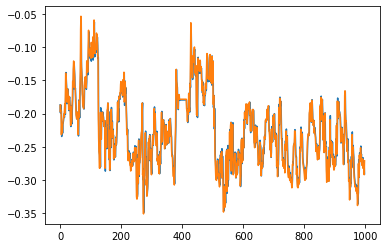

In [125]:
model.load_state_dict(torch.load('best_chkpt.pt'))
model.eval()
pred = run_on_inputs_with_targets(
    model, test_input, corrector_test_target, baseline_no_grad=True, model_mode=PRForecaster.MODE_TEST)

pred = test_out + pred
print_metrics(pred, test_target, 'With LSTM correction test')
N, S, one = test_target.shape
SEQ_IDX = 0
plt.figure()
plt.plot(np.arange(N), pred[:, SEQ_IDX, :].detach())
plt.plot(np.arange(N), test_target[:, SEQ_IDX, :].detach())
plt.show()

Metrics for With LSTM correction train:
	 MSE: 0.0006155947339721024
	 MAE: 0.017654111608862877
	 MAPE: 0.26241159439086914


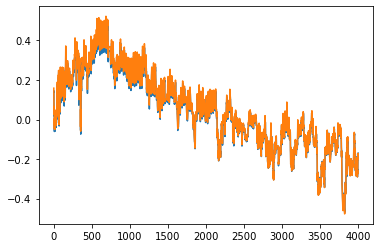

In [126]:
model.load_state_dict(torch.load('best_chkpt.pt'))
model.eval()
pred = run_on_inputs_with_targets(
    model, inp, corrector_train_target, baseline_no_grad=True, model_mode=PRForecaster.MODE_TEST)

pred = train_out + pred
print_metrics(pred, target, 'With LSTM correction train')
N, S, one = target.shape
SEQ_IDX = 0
plt.figure()
plt.plot(np.arange(N), pred[:, SEQ_IDX, :].detach())
plt.plot(np.arange(N), target[:, SEQ_IDX, :].detach())
plt.show()

In [134]:
model.load_state_dict(torch.load('best_chkpt.pt'))
model.eval()
# print(model.correction_scale_b)
# print(model.correction_scale_w)

RecurrentForecasterWithCorrectionBlock(
  (baseline): PrerecordedForecaster()
  (corrector): StackedRCellsForecaster(
    (cells): ModuleList(
      (0): RSPForecaster(
        (sigm_lin): Linear(in_features=11, out_features=6, bias=True)
        (w_ctx_cand_lin): Linear(in_features=11, out_features=6, bias=True)
      )
      (1): RSPForecaster(
        (sigm_lin): Linear(in_features=12, out_features=6, bias=True)
        (w_ctx_cand_lin): Linear(in_features=12, out_features=6, bias=True)
      )
    )
    (out_linear): Linear(in_features=11, out_features=1, bias=True)
  )
)

torch.Size([3998, 1, 1]) torch.Size([3998, 1, 1])
Metrics for model train:
	 MSE: 0.0004872787685599178
	 MAE: 0.015232525765895844
	 MAPE: 0.2283322960138321


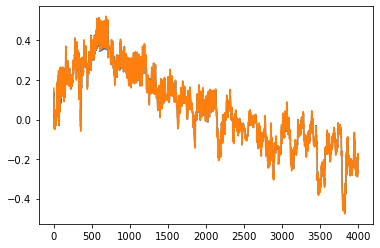

In [135]:
baseline.train_targets = train_out
with torch.no_grad():
    model_forecasts, _ = run_mod_with_correction_block_on_inputs_with_targets(
        model, inp, target, setup_ctxs=True, delete_ctxs=True, model_mode=PRForecaster.MODE_TRAIN)
    print(model_forecasts.shape, target.shape)
    print_metrics(model_forecasts, target, 'model train')
    N, S, one = target.shape
    SEQ_IDX = 0
    plt.figure()
    plt.plot(np.arange(N), model_forecasts[:, SEQ_IDX, :].detach())
    plt.plot(np.arange(N), target[:, SEQ_IDX, :].detach())
    plt.show()

torch.Size([998, 1, 1]) torch.Size([998, 1, 1])
Metrics for model test:
	 MSE: 0.0003578757168725133
	 MAE: 0.01348005048930645
	 MAPE: 0.06654009222984314


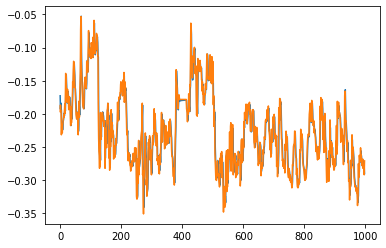

In [136]:
model.set_mode(PRForecaster.MODE_TEST)
with torch.no_grad():
    model_forecasts, _ = run_mod_with_correction_block_on_inputs_with_targets(
        model, test_input, test_target, setup_ctxs=True, delete_ctxs=True, model_mode=PRForecaster.MODE_TEST)
    print(model_forecasts.shape, test_target.shape)
    print_metrics(model_forecasts, test_target, 'model test')
    N, S, one = test_target.shape
    SEQ_IDX = 0
    plt.figure()
    plt.plot(np.arange(N), model_forecasts[:, SEQ_IDX, :].detach())
    plt.plot(np.arange(N), test_target[:, SEQ_IDX, :].detach())
    plt.show()

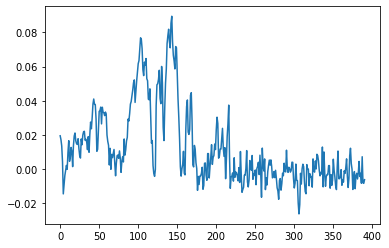

In [46]:
plt.plot(range(len(corrections[10:])), corrections[10:].squeeze())

In [16]:
print('''
loss: 0.00044439133489504457
test loss: 0.0004625237488653511
Elapsed time: 263.367878655 seconds.
Min test loss: 0.00046113631105981767
''')


loss: 0.00044439133489504457
test loss: 0.0004625237488653511
Elapsed time: 263.367878655 seconds.
Min test loss: 0.00046113631105981767



In [14]:
print(test_target.shape)

torch.Size([4, 88])


In [44]:
'RSP test loss: 0.0006836527948247121'

'RSP test loss: 0.0006836527948247121'

In [46]:
'Linear test loss: 0.00068016676907737'

'Linear test loss: 0.00068016676907737'